In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:
from architectures.MMNN import SinTUActivation,MMNN
from architectures.node import Parametric_NODE,init_node
from geometry.G_matrix import compute_Gv_vmap
from solvers import string_2_solver

In [3]:
from typing import Sequence, Callable, Optional, Dict, Any
from typing import List
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jrandom
import flax.linen as nn
from flax.core import copy
from jax import flatten_util
import optax
import diffrax

import matplotlib.pyplot as plt
# plt.style.use('figures/images_style.mplstyle')
import numpy as np

In [4]:
device = jax.devices()[0] if jax.devices() else jax.devices('cpu')[0]
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
# Create model 

d_space = 2
include_time = True
rank = 50
width = 356
n_layers = 5
if include_time:
    ranks = [d_space+1]+ [rank]*n_layers + [ d_space]     # Adjusted ranks for time
else:
    ranks = [2]+ [rank]*n_layers + [ 2]     # Adjusted ranks for no time
widths = [width]*(n_layers+1)      #


mmnn = MMNN(
    ranks=ranks,
    widths=widths,
    activation=SinTUActivation(),
    ResNet=False,
    FixWb=True
)

parameters = init_node(mmnn, d_space=d_space, include_time=include_time)


node = Parametric_NODE(
    model = mmnn,
    parameters=parameters,
    include_time=include_time,
    solver='euler',
    dt=0.01,
    history=False
)



In [6]:
t_ = jnp.linspace(0, 1, 20)
y0 = jnp.array([[0.0, 0.0]])

y1 = node.forward(
    parameters=parameters,
    t_list=t_,
    y0=y0,
    history=True
)

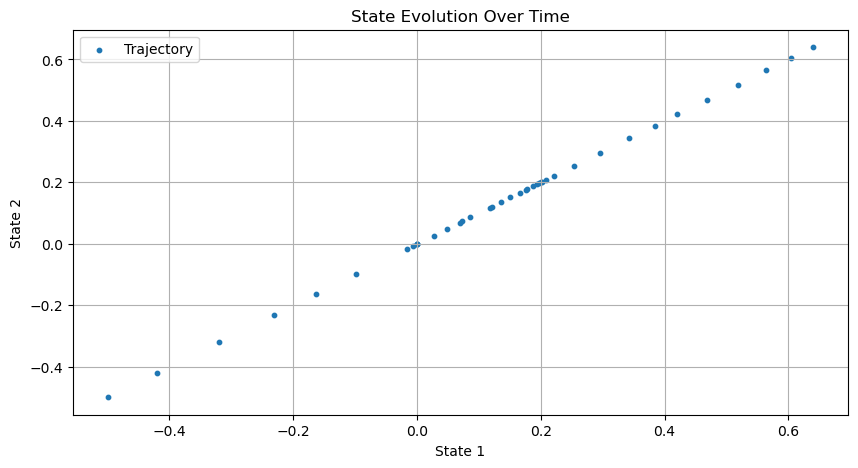

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(y1[:,0], y1[:,1], s=10, label='Trajectory')
plt.xlabel('State 1')
plt.ylabel('State 2')
plt.title('State Evolution Over Time')
plt.legend()
plt.grid()
plt.show()

# Computation of Gv MVP

In [9]:
key  = jrandom.PRNGKey(0)
n_samples = 1000

z_samples = jrandom.normal(key, (n_samples, d_space))


In [19]:
# Extract only trainable parameters  
trainable_params = parameters['params']  # Exclude 'fixed' collection
trainable_params = jax.tree.map(lambda x: jax.device_put(x, device), trainable_params)
# Create v only for trainable parameters
v_trainable = jax.tree.map(lambda x: jrandom.normal(key, x.shape)*0.2, trainable_params)
v_trainable = jax.device_put(v_trainable, device)
print(f"Number of parameters: {sum(jnp.size(leaf) for leaf in jax.tree.leaves(trainable_params))}")

z_samples = jax.device_put(z_samples,device)

Number of parameters: 89964


In [20]:
output = compute_Gv_vmap(node, parameters, v_trainable, z_samples, device, t_final=1, n_time_steps=20)
output_jnp = flatten_util.ravel_pytree(output)[0]  # Flatten the output for further processing if needed
print(output_jnp)

[-4.2314906 -4.752965   8.4861765 ... -1.4336398 60.050755  15.28906  ]
